# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [121]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import math
import warnings

RANDOM_STATE = 12345
warnings.filterwarnings('ignore')

In [122]:
taxi_data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [123]:
# general informatiom
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [124]:
taxi_data.sample(10)

,datetime,num_orders
15594,2018-06-17 07:00:00,3
21956,2018-07-31 11:20:00,16
17614,2018-07-01 07:40:00,8
20274,2018-07-19 19:00:00,15
3184,2018-03-23 02:40:00,5
17090,2018-06-27 16:20:00,20
24675,2018-08-19 08:30:00,19
13128,2018-05-31 04:00:00,23
11730,2018-05-21 11:00:00,21
23203,2018-08-09 03:10:00,13


In [125]:
# Change 'datetime' feature from object to datetime
taxi_data['datetime'] =  pd.to_datetime(taxi_data['datetime'])

In [126]:
# Check range of orders
print(f'min value= {taxi_data.num_orders.min()}')
print(f'max value= {taxi_data.num_orders.max()}')

min value= 0
max value= 119


In [127]:
# Check range of dates
print(f'min value= {taxi_data.datetime.min()}')
print(f'max value= {taxi_data.datetime.max()}')

min value= 2018-03-01 00:00:00
max value= 2018-08-31 23:50:00


In [128]:
# Set 'datetime' as index
taxi_data = taxi_data.set_index('datetime')
taxi_data.sort_index(inplace=True)

In [129]:
# Data before sampling
taxi_data.head(12)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [130]:
# sampling data by 1 hour
taxi_data = taxi_data.resample('1H').sum() 
# data after sampling 
taxi_data.head(24)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Analysis

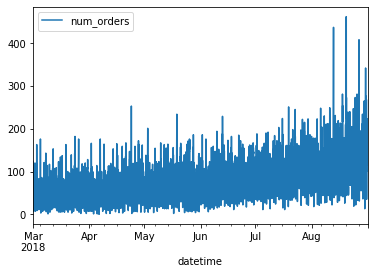

In [131]:
taxi_data.plot();

Text(0.5, 1.0, 'Trend')

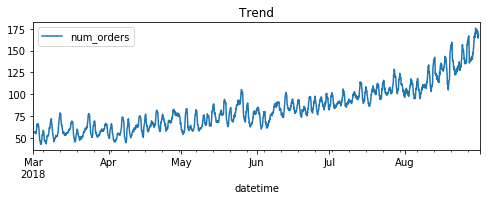

In [132]:
decomposed = seasonal_decompose(taxi_data)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')


Text(0.5, 1.0, '1 day Seasonality')

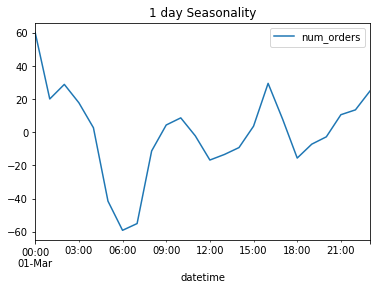

In [133]:
result = decomposed.seasonal['2018-03-01':'2018-03-01']
result.plot();
plt.title('1 day Seasonality')


#result = decomposed.trend['2018-03-02':'2018-03-02']
#result.plot();


Text(0.5, 1.0, '4 day Seasonality')

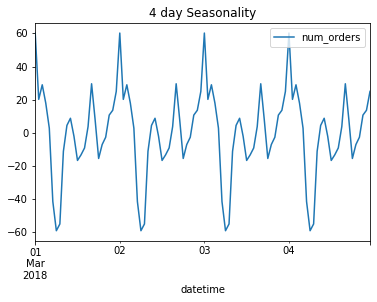

In [134]:
result = decomposed.seasonal['2018-03-01':'2018-03-04']
result.plot();
plt.title('4 day Seasonality')


### Conclusions
- peak hours:
    - 00:00
    - 2:00
    - 16:30
    - 23:00
- 00:00 is the most peak hour in the day
- There is an increase in demand over time

## Training & testing

In [135]:
# Create feuters 
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


In [136]:
# lag=7 because this in a weekly trend 
make_features(taxi_data, 7, 7)


In [137]:
# Split data to train and test sets
train, test = train_test_split(taxi_data, shuffle=False, test_size=0.1)
train = train.dropna()


In [138]:
# Create features & target
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)
target_train= train['num_orders']
target_test= test['num_orders']


In [139]:
def train_fit_score(model, params, name):
    tscv = TimeSeriesSplit(n_splits=5)
    model = GridSearchCV(model, param_grid=params, cv=tscv, verbose=0, refit=True)
    # Train the model 
    model.fit(features_train, target_train)
    
    # Predict the model     
    predict_train = model.predict(features_train)
    predict_test = model.predict(features_test)
     
    # RMSE Computation
    rmse_test = math.sqrt(mean_squared_error(target_test, predict_test))
    
    return pd.DataFrame([[name, rmse_test ]], columns=['Estimator', 'RMSE Score'])

In [140]:
# LinearRegression model
lr = train_fit_score(LinearRegression(),{},'Linear Regression')


In [141]:
# RandomForest
params = {'n_estimators' : range(10, 100, 15),
          'max_depth' : range(5, 15, 4),
          'min_impurity_decrease' : np.arange(.05, .1, .03),
          'min_samples_split' : [3,5]
         }

rf = train_fit_score(RandomForestRegressor(random_state=RANDOM_STATE),params,'Random Forest')    


In [142]:
# CatBoostRegressor
params = {'depth': range(6, 10,1),
          'learning_rate' : np.arange(.05, .1, .02),
          'iterations'    : range(10, 25, 3)
        }

CBR = train_fit_score(CatBoostRegressor() , params,'Cat Boost')  


0:	learn: 28.8816218	total: 1.04ms	remaining: 9.36ms
1:	learn: 28.2234601	total: 1.98ms	remaining: 7.93ms
2:	learn: 27.6192701	total: 2.84ms	remaining: 6.63ms
3:	learn: 27.0552421	total: 4.58ms	remaining: 6.87ms
4:	learn: 26.4354662	total: 5.45ms	remaining: 5.45ms
5:	learn: 25.8816503	total: 6.42ms	remaining: 4.28ms
6:	learn: 25.4301155	total: 7.6ms	remaining: 3.26ms
7:	learn: 24.9104604	total: 8.47ms	remaining: 2.12ms
8:	learn: 24.4792483	total: 9.29ms	remaining: 1.03ms
9:	learn: 24.0890112	total: 10.2ms	remaining: 0us
0:	learn: 29.7029902	total: 1.19ms	remaining: 10.7ms
1:	learn: 29.1188209	total: 2.38ms	remaining: 9.52ms
2:	learn: 28.5993109	total: 3.41ms	remaining: 7.95ms
3:	learn: 28.1385624	total: 4.45ms	remaining: 6.67ms
4:	learn: 27.5766178	total: 5.43ms	remaining: 5.43ms
5:	learn: 27.0246220	total: 6.4ms	remaining: 4.27ms
6:	learn: 26.6136126	total: 7.5ms	remaining: 3.21ms
7:	learn: 26.1430259	total: 8.51ms	remaining: 2.13ms
8:	learn: 25.7833393	total: 10.3ms	remaining: 1.14ms

In [143]:
# LightGBM Regressor
params = {
    'n_estimators': range(10, 120, 40),
    'colsample_bytree': np.arange(0.1, 0.9,0.5),
    'max_depth': range(10, 25, 10),
    'num_leaves': range(50, 200, 150),
    'reg_alpha': np.arange(1.1, 1.5, 0.4),
    'reg_lambda': np.arange(1.1, 1.3, 0.2),
    'min_split_gain': np.arange(0.3, 0.4,0.1),
    'subsample': np.arange(0.7, 0.9, 0.2),
    'subsample_freq': [20]
}

lgb_model = train_fit_score(lgb.LGBMRegressor(), params,'LightGBM')  


In [144]:
# Lasso Regressor
params = {'alpha' : np.arange(.01, 1, .05)}
#Create Lasso Regressor
Lasso = train_fit_score(Lasso(random_state=RANDOM_STATE),params,'Lasso')


In [145]:
# KNeighbors Regressor
params = {'n_neighbors' : range(2, 10, 1),
          'weights' : ['uniform', 'distance']}

KNNeighbors = train_fit_score(KNeighborsRegressor(),  params,'KNeighbors' )

                    

In [146]:
# XGBoost
params = {
    'n_estimators': range(10, 100, 20),
    'colsample_bytree': np.arange(0.1, 0.9,0.5),
    'max_depth': range(10, 25, 5),
    'num_leaves': range(50, 200, 100),
    'reg_alpha': np.arange(1.1, 1.5, 0.2),
    'reg_lambda': np.arange(1.1, 1.3, 0.1),
    'min_split_gain': np.arange(0.3, 0.4,0.1),
    'subsample': np.arange(0.7, 0.9, 0.1),
    'subsample_freq': [20]
}
xgb_model = train_fit_score(xgb.XGBRegressor(objective ='reg:squarederror',n_estimators = 10, seed = 123),  params,'XGBoost' )


In [147]:
scores = pd.concat([lr,rf,CBR, lgb_model, Lasso, KNNeighbors, xgb_model]).set_index('Estimator')
scores['RMSE Score'] = scores['RMSE Score'].round(2)
display(scores.sort_values('RMSE Score'))

,RMSE Score
Estimator,
LightGBM,44.90
Random Forest,46.43
XGBoost,49.86
Linear Regression,52.68
Lasso,52.68
Cat Boost,56.86
KNeighbors,59.62


## Conclusion

- LightGBM & Random Forest have RSME less than 48
- XGBoost had almost reached to 48 but even after changing hyperparameters, it didnt successed reaching the goal.